# Demo of Recurrent Neural Networks

In [1]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)

# Cleaning the Data 

In [2]:
# Daily Data on Gold.
tick = 'GC=F'
gold = web.get_data_yahoo(tick,'12/20/2015',interval='d')

In [3]:
gold

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-21,1081.900024,1070.199951,1070.199951,1081.900024,26.0,1081.900024
2015-12-22,1078.599976,1073.800049,1078.599976,1074.800049,106.0,1074.800049
2015-12-23,1074.800049,1069.400024,1074.500000,1069.400024,202.0,1069.400024
2015-12-24,1077.800049,1073.500000,1074.300049,1077.199951,24.0,1077.199951
2015-12-28,1098.800049,1070.500000,1077.900024,1070.500000,361.0,1070.500000
...,...,...,...,...,...,...
2020-12-14,1835.699951,1822.699951,1835.500000,1828.699951,258.0,1828.699951
2020-12-15,1853.599976,1833.199951,1833.500000,1852.300049,961.0,1852.300049
2020-12-16,1864.699951,1850.500000,1856.500000,1856.099976,1090.0,1856.099976


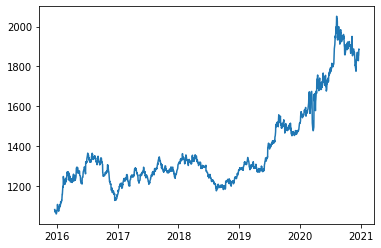

In [4]:
plt.plot(gold['Adj Close'])

In [5]:
returns = gold['Adj Close'].pct_change() # Used for univariate example.

column_names = gold.columns
x = gold.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [6]:
pct_c_gold = df

In [7]:
pct_c_gold.columns = column_names

In [8]:
pct_c_gold

,High,Low,Open,Close,Volume,Adj Close
0,0.019880,0.011920,0.008438,0.021989,0.000008,0.021989
1,0.016583,0.015588,0.016978,0.014828,0.000032,0.014828
2,0.012787,0.011105,0.012810,0.009381,0.000062,0.009381
3,0.015784,0.015283,0.012607,0.017248,0.000007,0.017248
4,0.036763,0.012226,0.016267,0.010490,0.000110,0.010490
...,...,...,...,...,...,...
1326,0.772927,0.778604,0.786499,0.775267,0.000079,0.775267
1327,0.790809,0.789302,0.784465,0.799072,0.000294,0.799072
1328,0.801898,0.806928,0.807849,0.802905,0.000333,0.802905
1329,0.833367,0.831075,0.825844,0.834275,0.000127,0.834275


# Univariate Forecasting (RNN)

In [9]:
returns

Date
2015-12-21         NaN
2015-12-22   -0.006563
2015-12-23   -0.005024
2015-12-24    0.007294
2015-12-28   -0.006220
                ...   
2020-12-14   -0.006033
2020-12-15    0.012905
2020-12-16    0.002051
2020-12-17    0.016756
2020-12-18   -0.000795
Name: Adj Close, Length: 1331, dtype: float64

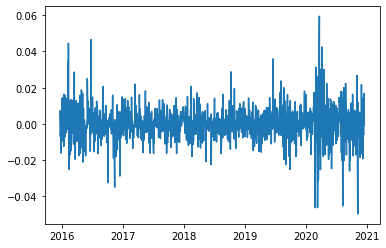

In [10]:
plt.plot(returns)

<AxesSubplot:>

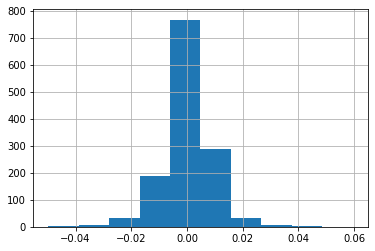

In [11]:
returns.hist()

In [12]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

1330
1330


In [13]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.39559946],
       [0.40967815],
       [0.52241392],
       [0.39873611],
       [0.51550642],
       [0.30786687],
       [0.4573878 ],
       [0.58340846],
       [0.48375329],
       [0.57023212]])]
Testing Data: Length is  1 :  [0.5880932447278658]


In [14]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (1320, 10, 1) Dimensions of Y (1320,)
Threshold is 1188


In [15]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 3 units.
model.add(layers.SimpleRNN(3,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3)                 15        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fitting the data
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
30/30 [==============================] - 2s 31ms/step - loss: 0.2193 - val_loss: 0.1606
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1259 - val_loss: 0.0872
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0512
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0472 - val_loss: 0.0412
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0378
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0322
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0300
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0279
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0264
Epoch 11

30/30 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0123
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 86/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 87/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 88/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 90/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 91/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 92/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 93/100


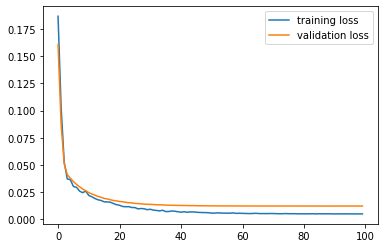

In [17]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

# Multi-Step Forecast

In [18]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions

true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]
for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

Number of Forecasts to do:  132


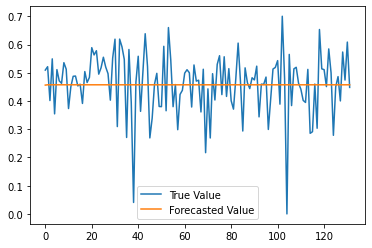

In [19]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

In [20]:
pct_c_gold

,High,Low,Open,Close,Volume,Adj Close
0,0.019880,0.011920,0.008438,0.021989,0.000008,0.021989
1,0.016583,0.015588,0.016978,0.014828,0.000032,0.014828
2,0.012787,0.011105,0.012810,0.009381,0.000062,0.009381
3,0.015784,0.015283,0.012607,0.017248,0.000007,0.017248
4,0.036763,0.012226,0.016267,0.010490,0.000110,0.010490
...,...,...,...,...,...,...
1326,0.772927,0.778604,0.786499,0.775267,0.000079,0.775267
1327,0.790809,0.789302,0.784465,0.799072,0.000294,0.799072
1328,0.801898,0.806928,0.807849,0.802905,0.000333,0.802905
1329,0.833367,0.831075,0.825844,0.834275,0.000127,0.834275


# Multi-Variate Forecasting

# Using our Training and Testing sets, Let's create our inputs.

In [21]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_gold.shape[0] - samples):
    X.append(pct_c_gold.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_gold.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[1.98801443e-02, 1.19204801e-02, 8.43831534e-03, 2.19891550e-02,
        7.94860554e-06],
       [1.65833922e-02, 1.55884349e-02, 1.69783973e-02, 1.48275902e-02,
        3.24058534e-05],
       [1.27872616e-02, 1.11054757e-02, 1.28100609e-02, 9.38072282e-03,
        6.17545507e-05],
       [1.57842646e-02, 1.52827305e-02, 1.26067758e-02, 1.72483106e-02,
        7.33717434e-06],
       [3.67632855e-02, 1.22261844e-02, 1.62667755e-02, 1.04902402e-02,
        1.10363331e-04],
       [1.76822689e-02, 1.93581253e-02, 1.74867340e-02, 1.75509623e-02,
        7.70403306e-05],
       [8.19175941e-03, 1.22256869e-03, 6.81166260e-03, 0.00000000e+00,
        2.17058074e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01808793e-04,
        3.05715598e-06],
       [2.04795205e-02, 4.78853915e-03, 1.52501020e-03, 1.51301187e-02,
        4.37173305e-05],
       [1.94805195e-02, 1.71167079e-02, 1.39283769e-02, 1.84587940e-02,
        2.50686790e-05

In [22]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1321, 10, 5) Dimensions of Y (1321, 1)


In [23]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1189, 10, 5) (1189, 1) Testing Length: (132, 10, 5) (132, 1)


In [24]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 30 internal units.
model.add(layers.SimpleRNN(30,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(trainX.shape[1], trainX.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                1080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
30/30 [==============================] - 1s 8ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 8.8090e-04
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 8.1309e-04 - val_loss: 0.0010
E

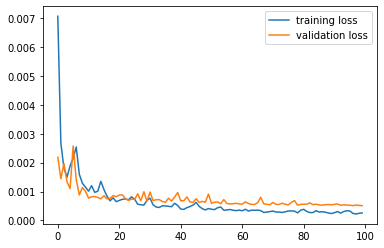

In [26]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

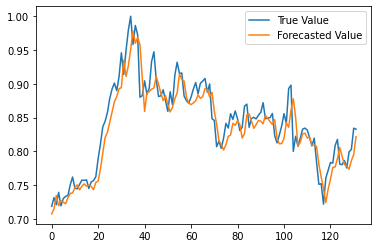

In [27]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
# Very much different from a univariate -- You will need predictions (or known) values for your independent values.
# Nonetheles, you will follow the same steps as shown for the univariate multi-step process.

In [ ]:
len(X[threshold:])